<a href="https://colab.research.google.com/github/Jovania/Machine_Learning/blob/master/Introdu%C3%A7%C3%A3o_ao_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução ao Scikit-Learn

## Introdução

[Scikit-Learn](https://scikit-learn.org/stable/), ou sklearn, é uma das principais bibliotecas Python para aprendizado de máquina. Ela fornece ferramentas para praticamente todas etapas do processo, desde carregamento e processamento de dados até criação e avaliação de modelos. Uma grande variedade de modelos e algoritmos de treinamento já vem inclusa, com uma interface uniforme de relativo fácil uso. Possui [extensiva documentação](https://scikit-learn.org/stable/user_guide.html) e uma comunidade ativa.

Mesmo quando se utiliza outras bibliotecas, até em outras linguagens, para treinar modelos mais complexos (e.g. PyTorch, TensorFlow), ainda é comum utilizar partes do sklearn para diversas etapas do pipeline. Assim, dominar o básico da biblioteca é fundamental para qualquer pesquisador ou praticante na área de aprendizado de máquina.

A biblioteca sklearn possui diversos módulos que organizam a API de acesso. Exemplos de módulo são `sklearn.linear_model`, que contém modelos lineares, ou `sklearn.datasets`, que contém métodos para criar ou carregar datasets. 

Aqui, utilizaremos a `sklearn.model_selection`, com métodos para pré-processamento e particionamento de datasets, bem como a `sklearn.tree`, que contém diversos modelos baseados em árvores de decisão.


# Carregando os dados

Ainda que seja possível carregar os dados diretamente com primitivas Python, é uma boa prática utilizar a biblioteca Pandas para isso. A biblioteca permite carregar dados de diferentes formatos de arquivos e lida bem com tipos diferentes de dados.

Como dataset, usaremos dados de 2017 retirados de diversas imobiliárias de Pelotas, com informações sobre imóveis. Nossa tarefa será classificar se um imóvel é uma Casa ou Apartamento a partir dos seus atributos.

In [ ]:
# Baixar os dados
!wget https://www.dropbox.com/s/skvenpz7p4szmoh/zap_imoveis.csv

# Vamos usar a biblioteca pandas para carregar e pré-processar os dados
import pandas as pd

dados_completos = pd.read_csv("zap_imoveis.csv", index_col=0)

--2020-10-15 22:52:25--  https://www.dropbox.com/s/skvenpz7p4szmoh/zap_imoveis.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/skvenpz7p4szmoh/zap_imoveis.csv [following]
--2020-10-15 22:52:25--  https://www.dropbox.com/s/raw/skvenpz7p4szmoh/zap_imoveis.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc95af2480814cec67e8679fc2ab.dl.dropboxusercontent.com/cd/0/inline/BBU8dlhBkCA7h3Pa-9UZ-u3SwFD_K8SOwqFmd8F77PBZdyzr491MvDivdHbD56kk72jYArFDOdC772j18Um5gRYjp8qgi63OtiTi--WfbsKOZT9rsmK1sHXSKvsafX-y0-0/file# [following]
--2020-10-15 22:52:26--  https://uc95af2480814cec67e8679fc2ab.dl.dropboxusercontent.com/cd/0/inline/BBU8dlhBkCA7h3Pa-9UZ-u3SwFD_K8SOwqFmd8F77PBZdyzr491MvDivdHbD56kk72jYArFDOdC772j18Um5gRYjp8qgi63OtiTi--Wfb

In [ ]:
# Filtrar para ficar apenas com imóveis do tipo Casa ou Apartamento
dados = dados_completos[(dados_completos['tipo_imovel']=='Casa') | (dados_completos['tipo_imovel']=='Apartamento')]

# Filtrar atributos que usaremos (sinta-se livre para experimentar com outros)
dados = dados[['num_suites', 'num_vagas', 'num_quartos',
       'area', 'bairro', 'preco', 'tipo_imovel']].reset_index(drop=True)

dados

,num_suites,num_vagas,num_quartos,area,bairro,preco,tipo_imovel
0,2.0,2.0,3.0,150.0,Laranjal,570000,Casa
1,0.0,0.0,0.0,360.0,Colina da Sol,200000,Casa
2,0.0,1.0,2.0,45.0,Centro,170000,Casa
3,0.0,1.0,2.0,55.0,Centro,250000,Casa
4,1.0,1.0,3.0,147.0,Centro,600000,Casa
...,...,...,...,...,...,...,...
3120,1.0,2.0,5.0,350.0,Recanto de Portugal,798000,Casa
3121,1.0,1.0,3.0,48.0,Três Vendas,226164,Apartamento
3122,1.0,1.0,2.0,69.0,Centro,370000,Apartamento
3123,0.0,1.0,3.0,76.0,Fragata,192000,Casa


# Preparação dos dados

Os dados já são relativamente limpos, não tendo valores faltando ou tipagem incorretas (como texto em uma coluna numérica por exemplo). É provável, porém, que existam valores  errados, bem como classes incorretamente atribuídas. Não tentaremos encontrar e corrigir estes erros.

Precisamos, porém, fazer um pré-processamento dos dados. Infelizmente, o algoritmo utilizado para árvores de decisão do sklearn não suporta diretamente atributos categóricos -- de fato, um grande problema do sklearn é que ele trabalha exclusivamente com atributos numéricos. O rótulo, porém, pode ser categórico.

O que precisamos fazer é converter os atributos categóricos para numéricos. O único atributo categórico no nosso dataset filtrado é `bairro`. Temos que fazer a conversão com cuidado, porém. Por exemplo, podemos estar tentados a mapear os valores categóricos diretamente para inteiros. Por exemplo, "Laranjal" para 1, "Centro" para 2 etc. Isto é incorreto, pois os valores não são ordinais; isto é, "Laranjal" não vem antes de "Centro". O mapeamento desta forma confundiria o algoritmo. Por exemplo, ele poderia tentar fazer médias e descobrir que a média entre "Laranjal" e "Colina do Sol" é "Centro", o que não faz sentido.

A maneira correta de abordar esta conversão é com a chamada codificação One Hot, onde cada valor será codificado como um novo atributo binário. Dado um atributo com V valores, convertemos o atributo para um vetor binário com V posições, todo zero exceto em uma posição que codifica o valor desejado. Por exemplo, considere o atributo `bairro` com valores ['Centro', 'Colina', 'Laranjal']. 

- bairro = 'Centro' seria codificado como [1,0,0].

- bairro = 'Colina' seria codificado como [0,1,0].

- bairro = 'Laranjal' seria [0,0,1].

Assim, teremos uma coluna por bairro, com valor binário, indicando se o bairro daquele exemplo é o bairro indicado pela coluna. 

Usaremos o método `LabelBinarizer` para isso.

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# No sklearn, é comum que todo método utilize a mesma API.
# Instanciamos primeiro o objeto e chamamos "fit" com os dados a serem processados.
# A escolha de "fit" é para manter a consistência com o treinamento de modelos, como veremos

# cod é o codificador genérico para bairros
cod = LabelBinarizer()
cod.fit(dados['bairro'])

# Com o codificador "treinado", convertemos os dados na coluna desejada
atributo_transformado = cod.transform(dados['bairro'])

# Agora reconvertemos para um dataframe em pandas 
# Mudamos o nome das colunas para refletir os valores originais
onehot = pd.DataFrame(atributo_transformado)
onehot.columns = cod.classes_

# Juntamos de volta com os dados originais e removemos a coluna categórica
dados_preparados = pd.concat([dados, onehot], axis=1).drop(['bairro'], axis=1)
dados_preparados

,num_suites,num_vagas,num_quartos,area,preco,tipo_imovel,Arco Iris,Areal,Baronesa,Barro Duro,Bom Jesus,Centro,Cohab II,Cohab Lindóia,Cohab Tablada,Cohabpel,Colina Verde,Colina da Sol,Cruzeiro,Fragata,Fátima,Guabiroba,Indeterminado,Jardim América,Jardim das Tradições,Laranjal,Laranjal Val Verde,Las Acácias,Lindóia,Navegantes,Obelisco,Pontal da Barra,Porto,Recanto de Portugal,Santa Terezinha,Simões Lopes,São Gonçalo,Sítio Floresta,Treptow,Três Vendas,Umuharama,Vila Assunção,Vila Jardim Europa,Vila Mariana,Vila Princesa,Zona Norte,Zona Rural
0,2.0,2.0,3.0,150.0,570000,Casa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,360.0,200000,Casa,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,1.0,2.0,45.0,170000,Casa,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,2.0,55.0,250000,Casa,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,3.0,147.0,600000,Casa,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,1.0,2.0,5.0,350.0,798000,Casa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3121,1.0,1.0,3.0,48.0,226164,Apartamento,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3122,1.0,1.0,2.0,69.0,370000,Apartamento,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3123,0.0,1.0,3.0,76.0,192000,Casa,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Separação dos dados

Separamos *aleatoriamente* os dados em dois conjuntos, **treinamento** e **teste**. O conjunto de treinamento será utilizado para treinar o modelo, enquanto o de teste será utilizado para avaliar o desempenho do modelo. Esta é a forma mais simples de avaliar um modelo e faz parte de uma família de métodos de avaliação chamada **validação cruzada**.

Esta separação é essencial pois, se avaliarmos diretamente no conjunto de treinamento teremos uma avaliação excessivamente *otimista* pois a avaliação ocorre em dados que já foram vistos pelo modelo. Por outro lado, a avaliação no conjunto de teste é *pessimista* pois temos que remover parte dos dados de treinamento para fazer a avaliação; estes dados são reintroduzidos no treinamento quando o modelo for colocado em produção e, portanto, espera-se que o modelo final tenha desempenho melhor em novos dados.

O método `train_test_split` será usado para criar a divisão. A documentação encontra-se [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Vamos usar 20% dos dados para teste, um valor razoavelmente padrão. Observe que há uma troca com este método de avaliação: um conjunto maior de validação aumenta nossa confiança no resultado da avaliação, mas reduz o desempenho do modelo por reduzir o conjunto de treino; de forma reversa, podemos treinar um modelo melhor aumentando o conjunto de treino, mas isso reduz nossa confiança na avaliação. 

In [ ]:
# O método train_test_split será utilizado para separação dos conjuntos
from sklearn.model_selection import train_test_split

treino, teste = train_test_split(dados_preparados, test_size=0.2)
print("Tamanhos dos conjuntos (treino, teste): ", len(treino), len(teste))

Tamanhos dos conjuntos (treino, teste):  2500 625


# Treinamento

Podemos treinar o modelo agora. Vamos utilizar uma árvore de decisão como modelo. O sklearn implementa o `DecisionTreeClassifier`, que é um modelo CART. Podemos aproximar o modelo do C4.5 usando entropia no lugar de gini para decidir os atributos em cada nó. De qualquer forma, este modelo lida automaticamente com atributos numéricos e implementa poda.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier(random_state=0, criterion="entropy")

# A função fit recebe como primeiro parâmetro uma matriz CxN, com C colunas e N linhas, onde cada linha especifica um exemplo
# O segundo parâmetro é um vetor com N posições, indicando os rótulos das linhas da matriz no primeiro parâmetro

X_treino = treino.drop('tipo_imovel', axis='columns')
y_treino = treino['tipo_imovel']
modelo_treinado = modelo.fit(X_treino, y_treino)

# Avaliação do modelo

Com o modelo treinado, temos que avaliá-lo no conjunto de teste. O sklearn implementa a maior parte das métricas comuns, bem como permite mostrar a matriz de confusão completa. 

In [ ]:
from sklearn.metrics import accuracy_score

# Separamos atributos e classe dos dados de teste
X_teste = teste.drop('tipo_imovel', axis='columns')
y_teste = teste['tipo_imovel']

# Passamos os exemplos sem classe pelo modelo treinado, que retorna a predicao em um vetor
predicoes = modelo_treinado.predict(X_teste)

# Com as predicoes, podemos calcular as métricas. Abaixo, a acurácia.
# Observe que sempre passamos os valores verdadeiros (y_teste) e depois as predicoes
acuracia = accuracy_score(y_teste, predicoes)
print("Acurácia do modelo: ", acuracia)


Acurácia do modelo:  0.8304


Obtemos 83% de acurácia. Mas o quão bom é isso? Observe que as classes não são perfeitamente balanceadas, o que dificulta a interpretação da acurácia -- se 83% dos exemplos forem de uma classe, o modelo poderia prever sempre a classe majoritária e obter 83% de acurácia. Não é o caso aqui já que o desbalanceamento é relativamente pequeno, mas é essencial examinarmos outras métricas. O sklearn fornece um "relatório" que sumariza as principais métricas, como abaixo.

In [ ]:
from sklearn.metrics import classification_report

relatorio = classification_report(y_teste, predicoes)
print(relatorio)

              precision    recall  f1-score   support

 Apartamento       0.82      0.85      0.84       323
        Casa       0.84      0.80      0.82       302

    accuracy                           0.83       625
   macro avg       0.83      0.83      0.83       625
weighted avg       0.83      0.83      0.83       625



Nada mal. Vemos que temos métricas razoáveis para as duas classes. O modelo parece ser capaz de aprender algo sobre os dados. Também é útil observamos a matriz de confusão. Diferente das funções anteriores, a função `plot_confusion_matrix` recebe o modelo treinado e os dados de teste e gera as predições internamente. Porém, também temos `confusion_matrix` que funciona como as funções anteriores, mas não gera um gráfico.

Na matriz de confusão, da esquerda para a direita e de cima para baixo, e considerando que Apartamento é a classe "positiva", temos a contagem do (i) número de Apartamentos que foram classificados como Apartmentos (Verdadeiros Positivos), (ii) número de Apartamentos que foram classificados como Casa (Falsos Negativos), (iii) número de Casas que foram classificadas como Apartamentos (Falsos Positivos) e (iv) número de Casas que foram classificadas como Casas (Verdadeiros Negativos). Desejamos que a maior parte das contagens esteja concentrada na diagonal principal da matriz.

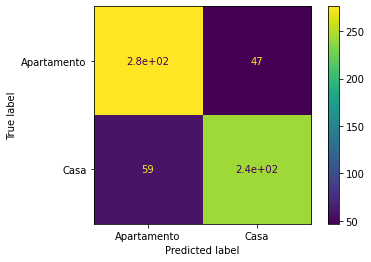

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(modelo_treinado, X_teste, y_teste)

# Melhorando a avaliação

Todas métricas acima foram derivadas do conjunto de teste, que compõe 20% do total de dados. O problema desta técnica é que, como os dados foram separados aleatoriamente, há a possibilidade de que a separação criou conjuntos muito diferentes entre si. Por exemplo, é possível que no teste (ou treino) não tenham aparecido casas muito caras já que elas não são muito frequentes nos dados. Esta disparidade pode gerar um resultado inacurado -- tanto melhor quanto pior do que o real. O problema é menor quanto maior for a quantidade e variedade de dados e ~3000 exemplos é uma quantidade razoável, mas podemos fazer melhor de qualquer forma.

## Bootstrapping

Uma primeira ideia é repetir o proceso todo várias vezes, criando uma separação aleatória a cada vez e treinando modelos independentes. Então, podemos pegar a média das métricas obtidas com cada modelo. Esta técnica de validação cruzada é chamada **bootstrapping**. Podemos usar a função `ShuffleSplit` do sklearn para isso.

In [ ]:
from sklearn.model_selection import ShuffleSplit

X = dados_preparados.drop('tipo_imovel', axis='columns')
y = dados_preparados['tipo_imovel']

# Vamos criar 10 separações, mantendo 20% de teste em cada uma
rs = ShuffleSplit(n_splits=10, test_size=.2)

# List para armazernamos as acurácias de cada modelo
acuracias = []

# Agora iteramos por cada separação e treinamos um modelo
# O método split retorna índices para o vetor passado como parametro
# O .loc é a maneira de indexar tabelas no pandas a partir de índices
for train_index, test_index in rs.split(X):
  modelo_treinado = modelo.fit(X.loc[train_index], y.loc[train_index])
  predicoes = modelo_treinado.predict(X.loc[test_index])
  acuracias.append(accuracy_score(y.loc[test_index], predicoes))

print(acuracias)
print("Média das acurácias: ", sum(acuracias) / len(acuracias))
#Uma abordagem seria estratificar a separação entre treino/teste. A estratificação procura garantir que a distribuição dos dados é semelhante entre os grupos. Ela pode ser feita tanto para atributos como para rótulos. 


[0.8384, 0.7984, 0.7904, 0.8064, 0.8144, 0.8144, 0.7904, 0.8112, 0.8016, 0.8272]
Média das acurácias:  0.80928


A acurácia ficou em cerca de 81%, muito próximo dos 83% anteriores. Você pode obter valores levemente diferentes se executar a célula novamente, pois separações aleatórias diferentes serão feitas -- uma boa prática em geral, não adotada aqui, é passar o parâmetro `random_seed` com um inteiro qualquer para todas funções que possuam aleatoriedade, de forma a garantir reprodutibilidade.

Esta acurácia de 81% é uma estimativa *melhor* que a anterior, pois é o resultado de diversos testes. Quanto mais execuções fizermos, melhor será a estimativa. Porém, para modelos complexos e muitos dados, rodar um número elevado de vezes pode ser proibitivo pelo tempo necessário.

Ainda que a abordagem na célula acima seja razoável, não há garantia de que todos exemplos participarão do treino e do teste para alguma execução. Idealmente, gostaríamos que isso ocorresse pois queremos treinar e testar o modelo na maior variedade possível de dados.

## K-Fold

Uma alternativa a esta abordagem é denominada validação cruzada *k-fold* (k-partições? Não há uma boa tradução ainda.). A ideia é embaralhar os dados e então dividí-los em *k* partições. Então, separamos a primeira partição como teste e treinamos um modelo nas *k-1* partições restantes; na sequência, separamos a *segunda* partição como teste e treinamos outro modelo nas restantes e assim por diante até que todas partições tenham participado do teste. 

Com isso, treinamos *k* modelos sobre dados diferentes. Como antes, podemos pegar as médias de cada métrica para usarmos como estimativas.

O sklearn nos fornece uma função que automatiza o processo e não precisamos criar o loop manualmente como fizemos antes. Esta função é a `cross_val_score`.

In [ ]:
from sklearn.model_selection import cross_val_score

# O parâmetro cv indica quantas partições criaremos
scores = cross_val_score(modelo, X, y, cv=10)
print("Acurácia média: ", scores.mean())

Acurácia média:  0.8144087408863767


No limite, podemos fazer com que *k* seja igual ao número de exemplos. Quando isso ocorre, chamamos a técnica de **leave-one-out** (deixe-um-de-fora?). Esta técnica é bastante custosa, mas provê a melhor estimativa possível pois cada modelo tem acesso a praticamente a todos exemplos (menos um) no treinamento e todos exemplos são eventualmente usados para teste. 


# Cuidados no uso de validação cruzada 

De forma geral, k-fold tende a ser o método preferido e k=10 tende a ser o padrão. Porém, para modelos complexos e/ou uma grande quantidade de dados pode-se utilizar valores menores ou apenas usar uma única divisão treino/teste. 

Há casos onde nenhum desses métodos é adequado. Um deles é quando estamos trabalhando com séries temporais - dados que seguem temporalmente um ao outro. Por exemplo, o valor de preço de imóveis a cada ano. Nesse caso, tipicamente a tarefa é criar predições para o futuro e **não podemos usar dados futuros para prever dados do passado**. Se simplesmente colocarmos todos exemplos em um grande conjunto e separarmos aleatoraimente, é inevitável que a ordem temporal não será respeitada. Assim, precisamos garantir que exemplos de teste possuem datas posteriores aos do treino. Por exemplo, poderíamos treinar em dados de 2000 até 2015 e testar em dados de 2016 até 2020. 

Se não respeitarmos a ordem temporal, criamos  um **vazamento de dados** (*data leakage*), termo dado para quando usamos no treinamento algum dado que não estaria disponível se o modelo estivesse em produção, operando na vida real. Neste caso, não teríamos dados futuros e, portanto, não devemos avaliar o modelo com esses dados.

Em geral, se há possibilidade de vazamento de dados, estes métodos de avaliação não são aconselháveis e deve-se criar os conjuntos de treino e teste de forma mais criteriosa. 

Outro exemplo de vazamento de dados poderia ocorrer em sistemas de reconhecimento de faces. Nestes sistemas, queremos que o modelo diga se há uma face em uma foto ou não. Digamos que nossa base de dados contenha 100 pessoas distintas e 100 fotos de cada pessoa em situações diferentes. Se simplesmente aleatorizarmos a separação treino/teste, é virtualmente garantido que fotos da mesma pessoa aparecerão tanto no treino como no teste. O problema aqui é mais sutil, mas note que a tarefa original não é reconhecer o rosto DESTAS pessoas, mas de *qualquer* pessoa. Ao permitir que a mesma pessoa apareça em ambos conjuntos, estamos alterando a tarefa e medindo o desempenho nesta tarefa alterada.

A solução para este caso é garantir que pessoas diferentes estejam no treino e no teste. Selecionaríamos talvez 80% das *pessoas* para o conjunto de treino e os 20% restantes para o teste, incluindo *todas* fotos dessas pessoas nos respectivos conjuntos.


# Qual modelo colocar em produção?

Todas técnicas de validação cruzada treinam modelos sub-ótimos, pois separamos alguns exemplos para teste. Adicionalmente, no bootstrapping e k-fold, treinamos vários modelos -- qual deles é o modelo que devemos usar? Um erro comum é querer pegar o *melhor* modelo entre os gerados, mas isso é exatamente o que não queremos fazer; o melhor modelo é o melhor segundo a ótica do conjunto de teste selecionado naquele momento. De certa forma, escolheríamos o modelo que melhor se ajusta a uma quantidade limitada de exemplos; isto é, que se sobreajusta ao problema e, portanto, terá menor capacidade de generalização e desempenho pior em produção.

O que precisamos nos dar conta é que todas estas técnicas servem apenas para estimar o desempenho do modelo. São úteis para termos alguma estimativa sobre como o modelo deve se comportar no mundo real, ou talvez para anunciar no website ao vendermos o modelo. Mas finalizada a etapa de avaliação, devemos treinar o modelo final usando **todos** dados disponíveis. Este modelo tipicamente não será pior que a estimativa obtida, pois foi treinado com mais dados. De fato, a estimativa é pessimista, pois não demos todos dados para o modelo durante a etapa de avaliação. Para finalizar este tutorial, vamos fazer exatamente isso.

In [ ]:
X = dados_preparados.drop('tipo_imovel', axis=1)
y = dados_preparados['tipo_imovel']

modelo_final = modelo.fit(X,y)

# E podemos agora colocar em produção e usá-lo
bairro = list(cod.transform(['Fragata'])[0])
predicao = modelo_final.predict([[2, 0, 1, 120] + bairro + [250000]])
print(predicao)

['Apartamento']
